---
# <center>  Master M2 MVA - Extremes Values
    
# <center> Tail Inverse Regression: dimension reduction for prediction of extremes
    
<center> paper : https://hal.science/hal-04032206/document
<center> Thomas LI | Max Kramkimel
    
---

# Imports


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MVA/Extreme values/TIREX_example
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MVA/Extreme values/TIREX_example


In [2]:
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from TIREX_src import TIREX # from the github link in the paper
import warnings
warnings.filterwarnings('ignore')

# Create toy dataset

In [10]:
N = 10000
p = 100
d = 2
quantile = 0.9

def create_gaussian_dataset(N, p, d, quantile = 0.9, noise = 1.):
  X = np.random.randn(N, p)
  beta = np.zeros(p)
  beta[:d] = 1
  Y_noise = noise * np.random.randn(N)
  Y = X @ beta + Y_noise

  q_90 = np.quantile(Y, quantile)# getting the quantile

  stratifier = np.where(Y >= q_90,1,0)

  X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,stratify = stratifier)

  X_test_extreme=X_test[Y_test>=q_90]
  Y_test_extreme=Y_test[Y_test>=q_90]

  Y_train_classif =np.where(Y_train >= q_90,1,0)
  Y_test_classif  =np.where(Y_test >= q_90,1,0)

  return X_train, X_test, Y_train_classif, Y_test_classif, Y_train,Y_test

X_train, X_test, Y_train_classif, Y_test_classif, Y_train,Y_test = create_gaussian_dataset(N, p, d, quantile = quantile)


In [13]:
X_train.shape

(140, 500)

# Choice of K in the Tirex and CUME algorithms by cross validation

In [15]:
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score as AUC


dim= 2# Desired number of components
n=len(X_train) # Length of dataset
k_base=int(sqrt(n)) # extreme treshhold



L_k=[i*k_base for i in range(1,10)]
model=KNeighborsClassifier(n_neighbors=5)
model=LogisticRegression(penalty=None)

def cross_val_k(X_train,Y_train_classif,L_k,method, model = model):
    L_AUC_val=np.zeros((len(L_k),1))
    for i,k in enumerate(L_k):
        print("STEP N° :",i+1,"/",len(L_k))
        Tirex=TIREX(n_components=dim,k=k,method=method)
        Tirex.fit(X_train,Y_train_classif)
        X_sliced_train=Tirex.transform(X_train)
        kf= KFold(n_splits=5)
        regressor_Sliced=Pipeline([('sclr',StandardScaler()), ('m',model)])
        L_simu_auc=[]

        for (train_index, test_index) in kf.split(X_sliced_train,Y_train_classif):

            X_train_cv,X_test_cv = X_sliced_train[train_index],X_sliced_train[test_index]
            Y_train_classif_cv,Y_test_classif_cv = Y_train_classif[train_index],Y_train_classif[test_index]

            regressor_Sliced.fit(X_train_cv,Y_train_classif_cv)


            Y_pred_class=regressor_Sliced.predict_proba(X_test_cv)[:,1]

            L_simu_auc.append(AUC(Y_test_classif_cv,Y_pred_class))
        L_AUC_val[i,:]=sum(L_simu_auc)/len(L_simu_auc)

    return L_k[np.argmax(L_AUC_val)]


X_train, X_test, Y_train_classif, Y_test_classif, Y_train,Y_test = create_gaussian_dataset(200, 500, 2, quantile = 0.9)

k_opt_FO=cross_val_k(X_train,Y_train_classif,L_k,"FO")
k_opt_SO=cross_val_k(X_train,Y_train_classif,L_k,"SO")



STEP N° : 1 / 9
STEP N° : 2 / 9
STEP N° : 3 / 9
STEP N° : 4 / 9
STEP N° : 5 / 9
STEP N° : 6 / 9
STEP N° : 7 / 9
STEP N° : 8 / 9
STEP N° : 9 / 9
STEP N° : 1 / 9
STEP N° : 2 / 9
STEP N° : 3 / 9
STEP N° : 4 / 9
STEP N° : 5 / 9
STEP N° : 6 / 9
STEP N° : 7 / 9
STEP N° : 8 / 9
STEP N° : 9 / 9


# Test Model

In [18]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score as ACC
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from numpy import linalg as LA
from sklearn.linear_model import LogisticRegression


def get_AM_risk(y_true, y_pred):
  y_pred_int = np.round(y_pred)
  c_matrix = confusion_matrix(y_true, y_pred_int)
  left = c_matrix[0,1] / (c_matrix[0,0] + c_matrix[0,1])
  right = c_matrix[1,0] / (c_matrix[1,0] + c_matrix[1,1])
  AM_risk = 0.5*(left + right)
  return AM_risk


#function to test the model
def test_model(algo,model,X_train,Y_train_classif,X_test,Y_test_classif, plot = False):
    predictions_storage_AUC=dict()
    predictions_storage_AM_risk=dict()
    for algo_name, algo_reduce  in algo.items():
            if algo_name=="all features":
                steps=[('sclr',StandardScaler()), ('m', model)]
            elif algo_name =="penalty_l1":
                steps=[('sclr',StandardScaler()), ('m', LogisticRegression(solver='saga',penalty="l1"))]
            elif algo_name =="penalty_l2":
                steps=[('sclr',StandardScaler()), ('m', LogisticRegression(penalty="l2"))]
            else:
                steps=[(algo_name,algo_reduce),('sclr',StandardScaler()), ('m', model)]

            model_f= Pipeline(steps=steps)
            model_f.fit(X_train,Y_train_classif)

            if "TIREX" in algo_name and plot:
              sub_model = model_f[algo_name]
              CentralSpace_X = sub_model.CentralSpace_X
              plt.bar(np.arange(CentralSpace_X.shape[0]), CentralSpace_X[:,0], label = "PC1", alpha = 0.5)
              plt.bar(np.arange(CentralSpace_X.shape[0]), CentralSpace_X[:,1], label = "PC2", alpha = 0.5)
              plt.title(algo_name)
              plt.legend()
              plt.show()

            predictions_f=model_f.predict_proba(X_test)[:,1]

            AUC_score = AUC(Y_test_classif,predictions_f)
            AM_risk = get_AM_risk(Y_test_classif,predictions_f)

            predictions_storage_AUC[algo_name]=AUC_score
            predictions_storage_AM_risk[algo_name]=AM_risk

    return predictions_storage_AUC, predictions_storage_AM_risk

# Visualizing on one experiment

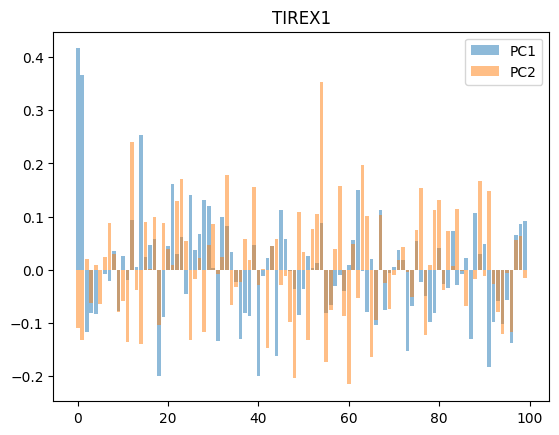

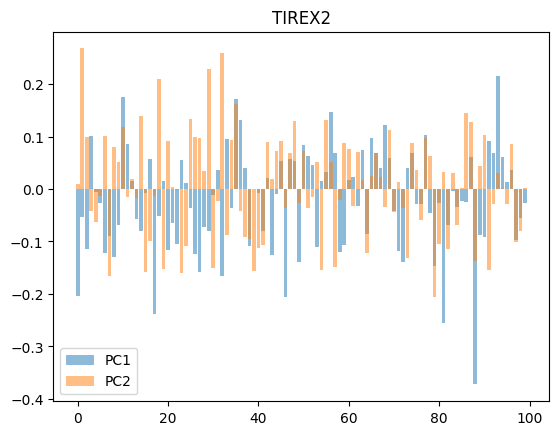

In [21]:
N = 10000
p = 100
d = 2
quantile = 0.9

X_train, X_test, Y_train_classif, Y_test_classif, Y_train,Y_test = create_gaussian_dataset(N, p, d, quantile = quantile)

algo={"TIREX1":TIREX(k=k_opt_FO,n_components=dim,method="FO", get_SDR_X=True),"TIREX2":TIREX(k=k_opt_SO,n_components=dim,method="SO",get_SDR_X=True)}


predictions_extreme_storage=test_model(algo,model,X_train,Y_train_classif,X_test,Y_test_classif, plot = True)

# Main p_over_n

In [ ]:


from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.manifold import Isomap,LocallyLinearEmbedding
from math import sqrt


N_tests = 20

# algo={"all features":None,"tirex_first_order":TIREX(k=k_opt_FO,n_components=dim,method="FO"),"tirex_second_order":TIREX(k=k_opt_SO,n_components=dim,method="SO"),"CUME FO":TIREX(n_components=dim,method="FO",mode="CUME"),"CUME SO":TIREX(n_components=dim,method="SO",mode="CUME"),'PCA':PCA(n_components=dim),'SVD':TruncatedSVD(n_components=dim),"LLE":LocallyLinearEmbedding(n_components=dim,eigen_solver="dense"),"IMP":Isomap(n_components=dim,eigen_solver="dense")}

# algo={"all features":None,"penalty_l2":None,"penalty_l1":None,"tirex_first_order":TIREX(k=k_opt_FO,n_components=dim,method="FO"),"tirex_second_order":TIREX(k=k_opt_SO,n_components=dim,method="SO")}

N_list = [200, 300, 500,1000,2000,3000,5000]
p_list = [500]*len(N_list)
d_list = [2]*len(N_list)
quantile_list = [0.9] * len(N_list)

dim = 2
model = LogisticRegression(penalty=None)
# model = RandomForestClassifier()

algo_names = ["all features", "penalty_l2", "penalty_l1", "tirex_first_order", "tirex_second_order"]
predictions_storage_AUC_multiple = pd.DataFrame(columns = algo_names)
predictions_storage_AM_risk_multiple = pd.DataFrame(columns = algo_names)
fast_choice_of_k = True

for i in range(len(N_list)):
  print("Setup", i)
  N = N_list[i]
  p = p_list[i]
  d = d_list[i]
  quantile = quantile_list[i]

  X_train, X_test, Y_train_classif, Y_test_classif, Y_train,Y_test = create_gaussian_dataset(N, p, d, quantile = quantile)
  n=len(X_train) # Length of dataset
  k_base=int(sqrt(n)) # extreme treshhold
  # choice of K (the paper also proposes also k = n^(2/3))
  if fast_choice_of_k:
    k_opt_FO=4*int(n**(0.66))
    k_opt_SO=4*int(n**(0.66))
  else:
    L_k = [k_base*i for i in range(1,12,2)]
    k_opt_FO=cross_val_k(X_train,Y_train,L_k,"FO")
    k_opt_SO=cross_val_k(X_train,Y_train,L_k,"SO")

  algo={"all features":None,"penalty_l2":None,"penalty_l1":None,"tirex_first_order":TIREX(k=k_opt_FO,n_components=dim,method="FO"),"tirex_second_order":TIREX(k=k_opt_SO,n_components=dim,method="SO")}

  for j in range(N_tests):
    X_train, X_test, Y_train_classif, Y_test_classif, Y_train,Y_test = create_gaussian_dataset(N, p, d, quantile = quantile)
    predictions_storage_AUC, predictions_storage_AM_risk = test_model(algo,model,X_train,Y_train_classif,X_test,Y_test_classif)
    # predictions_storage_AUC, predictions_storage_AM_risk = pd.DataFrame(predictions_storage_AUC), pd.DataFrame(predictions_storage_AM_risk)
    # predictions_storage_AUC_multiple = pd.concat([predictions_storage_AUC_multiple, predictions_storage_AUC], ignore_index=True)
    # predictions_storage_AM_risk_multiple = pd.concat([predictions_storage_AM_risk_multiple, predictions_storage_AM_risk], ignore_index=True)
    predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
    predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)

list_p_over_N = []
list_quantile = []
for i in range(len(N_list)):
    list_p_over_N += [p_list[i]/N_list[i]]*N_tests
    list_quantile += [quantile_list[i]]*N_tests


predictions_storage_AUC_multiple["p_over_N"] = np.array(list_p_over_N)
predictions_storage_AM_risk_multiple["p_over_N"] = np.array(list_p_over_N)

predictions_storage_AUC_multiple["quantile"] = np.array(list_quantile)
predictions_storage_AM_risk_multiple["quantile"] = np.array(list_quantile)

Setup 0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-15-c9dfc0e2af8f>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The fra

Setup 1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-15-c9dfc0e2af8f>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The fra

Setup 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-15-c9dfc0e2af8f>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The fra

Setup 3


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-15-c9dfc0e2af8f>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The fra

Setup 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-15-c9dfc0e2af8f>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The fra

Setup 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-15-c9dfc0e2af8f>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The fra

Setup 6


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-15-c9dfc0e2af8f>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-15-c9dfc0e2af8f>:54: FutureWarning: The fra

In [ ]:
def plot_results(predictions_storage_AUC_multiple, predictions_storage_AM_risk_multiple, x_axis = "p_over_N"):
  if x_axis == "p_over_N":
    predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.groupby('p_over_N', as_index=False).mean()
    predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.groupby('p_over_N', as_index=False).mean()

    predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.set_index("p_over_N")
    predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.drop("quantile", axis = 1)
    predictions_storage_AUC_multiple.plot()
    plt.title("AUC")
    plt.show()

    predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.set_index("p_over_N")
    predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.drop("quantile", axis = 1)
    predictions_storage_AM_risk_multiple.plot()
    plt.title("AM_risk")
    plt.show()
  else:
    predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.groupby('quantile', as_index=False).mean()
    predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.groupby('quantile', as_index=False).mean()

    predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.set_index("quantile")
    predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.drop("p_over_N", axis = 1)
    predictions_storage_AUC_multiple.plot()
    plt.title("AUC")
    plt.show()

    predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.set_index("quantile")
    predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.drop("p_over_N", axis = 1)
    predictions_storage_AM_risk_multiple.plot()
    plt.title("AM_risk")
    plt.show()

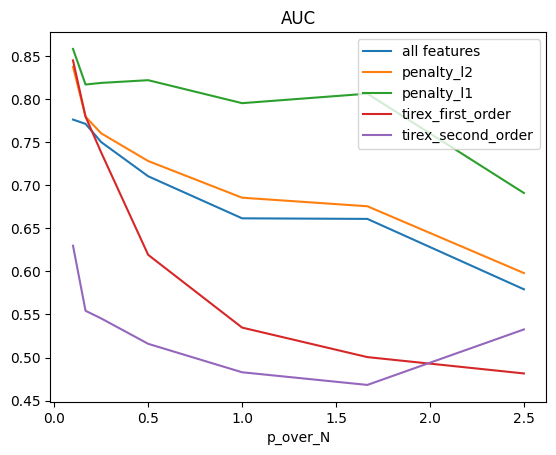

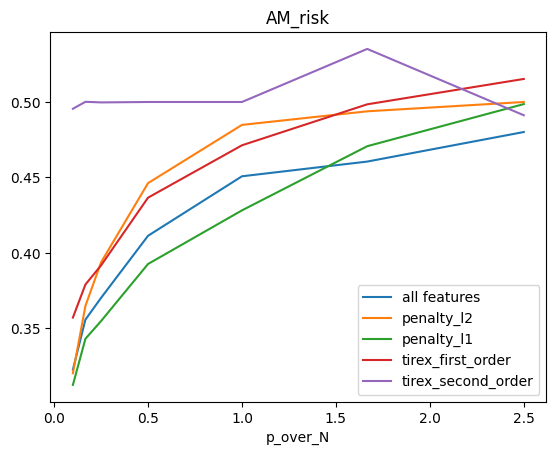

In [ ]:
# logisitic moyenné sur 20

plot_results(predictions_storage_AUC_multiple, predictions_storage_AM_risk_multiple, x_axis = "p_over_N")

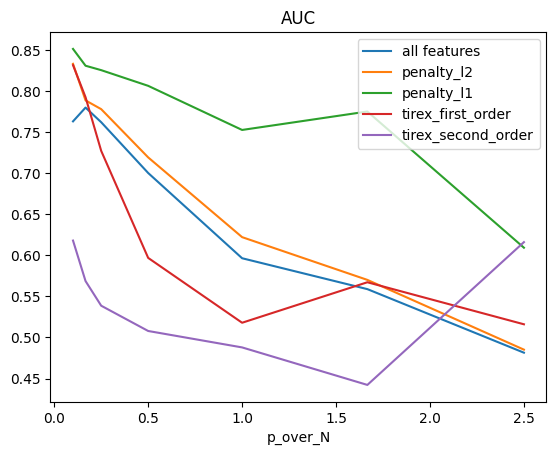

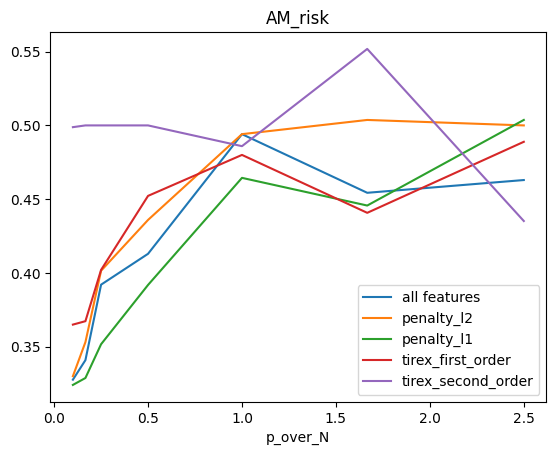

In [ ]:
# logisitic moyenné sur 5

plot_results(predictions_storage_AUC_multiple, predictions_storage_AM_risk_multiple, x_axis = "p_over_N")

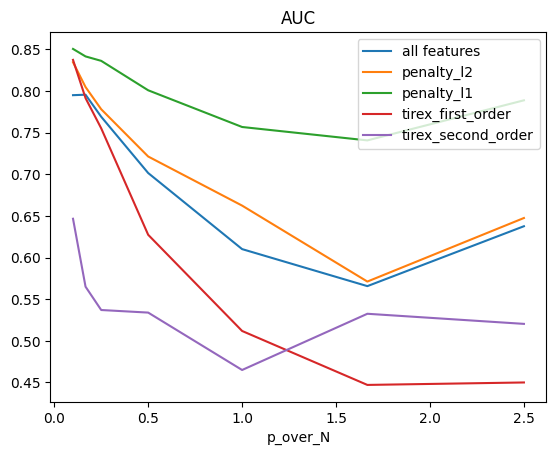

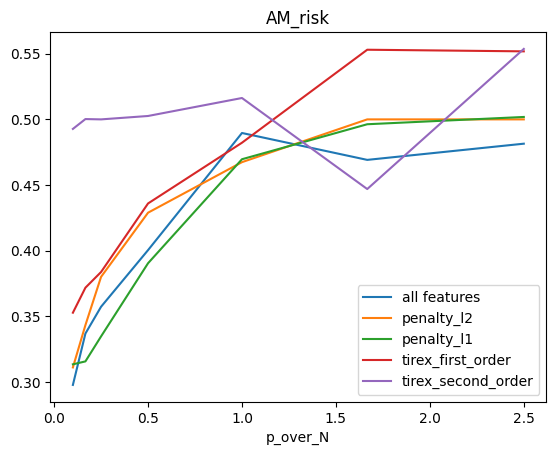

In [ ]:
# logisitic moyenné sur 5
plot_results(predictions_storage_AUC_multiple, predictions_storage_AM_risk_multiple, x_axis = "p_over_N")

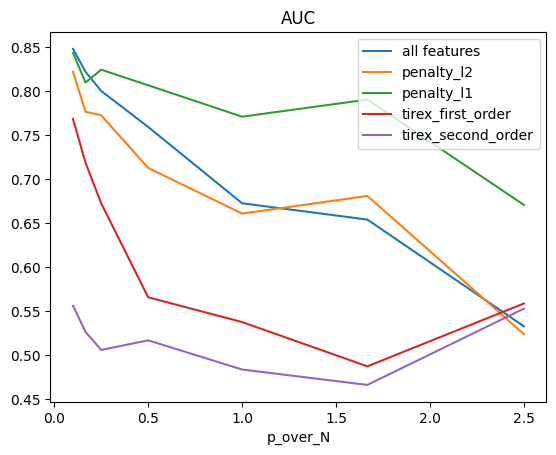

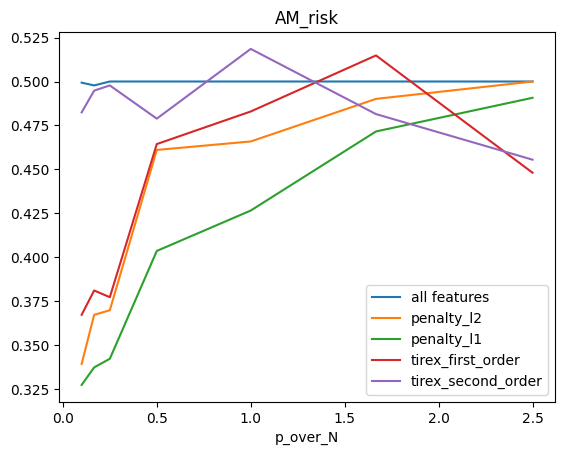

In [ ]:
# Random Forest classifier moyenné sur 5
plot_results(predictions_storage_AUC_multiple, predictions_storage_AM_risk_multiple, x_axis = "p_over_N")

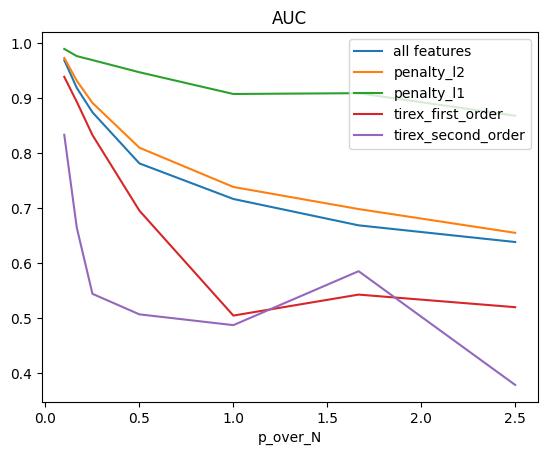

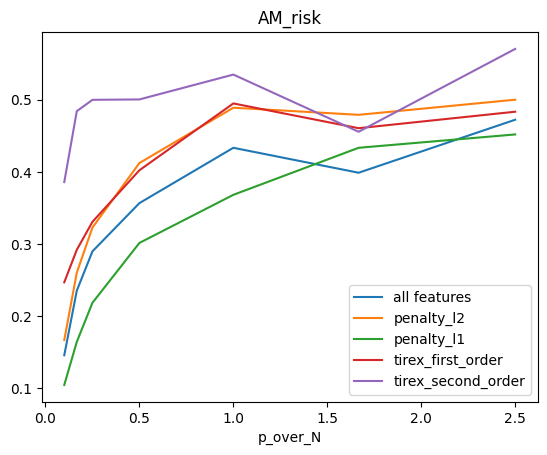

In [ ]:
plot_results(predictions_storage_AUC_multiple, predictions_storage_AM_risk_multiple, x_axis = "p_over_N")

# Main quantile

In [ ]:


from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.manifold import Isomap,LocallyLinearEmbedding
from math import sqrt


N_tests = 20

# algo={"all features":None,"tirex_first_order":TIREX(k=k_opt_FO,n_components=dim,method="FO"),"tirex_second_order":TIREX(k=k_opt_SO,n_components=dim,method="SO"),"CUME FO":TIREX(n_components=dim,method="FO",mode="CUME"),"CUME SO":TIREX(n_components=dim,method="SO",mode="CUME"),'PCA':PCA(n_components=dim),'SVD':TruncatedSVD(n_components=dim),"LLE":LocallyLinearEmbedding(n_components=dim,eigen_solver="dense"),"IMP":Isomap(n_components=dim,eigen_solver="dense")}

# algo={"all features":None,"penalty_l2":None,"penalty_l1":None,"tirex_first_order":TIREX(k=k_opt_FO,n_components=dim,method="FO"),"tirex_second_order":TIREX(k=k_opt_SO,n_components=dim,method="SO")}

quantile_list = [0.8, 0.9, 0.95, 0.98, 0.99, 0.995]
N_list = [5000]*len(quantile_list)
p_list = [100]*len(quantile_list)
d_list = [2]*len(quantile_list)

dim = 2
model = LogisticRegression(penalty=None)

algo_names = ["all features", "penalty_l2", "penalty_l1", "tirex_first_order", "tirex_second_order"]
predictions_storage_AUC_multiple = pd.DataFrame(columns = algo_names)
predictions_storage_AM_risk_multiple = pd.DataFrame(columns = algo_names)
fast_choice_of_k = True

for i in range(len(N_list)):
  print("Setup", i)
  N = N_list[i]
  p = p_list[i]
  d = d_list[i]
  quantile = quantile_list[i]

  X_train, X_test, Y_train_classif, Y_test_classif, Y_train,Y_test = create_gaussian_dataset(N, p, d, quantile = quantile)
  n=len(X_train) # Length of dataset
  k_base=int(sqrt(n)) # extreme treshhold
  # choice of K (the paper also proposes also k = n^(2/3))
  if fast_choice_of_k:
    k_opt_FO=4*int(n**(0.66))
    k_opt_SO=4*int(n**(0.66))
  else:
    L_k = [k_base*i for i in range(1,12,2)]
    k_opt_FO=cross_val_k(X_train,Y_train_classif,L_k,"FO")
    k_opt_SO=cross_val_k(X_train,Y_train_classif,L_k,"SO")

  algo={"all features":None,"penalty_l2":None,"penalty_l1":None,"tirex_first_order":TIREX(k=k_opt_FO,n_components=dim,method="FO"),"tirex_second_order":TIREX(k=k_opt_SO,n_components=dim,method="SO")}

  for j in range(N_tests):
    X_train, X_test, Y_train_classif, Y_test_classif, Y_train,Y_test = create_gaussian_dataset(N, p, d, quantile = quantile)
    predictions_storage_AUC, predictions_storage_AM_risk = test_model(algo,model,X_train,Y_train_classif,X_test,Y_test_classif)
    # predictions_storage_AUC, predictions_storage_AM_risk = pd.DataFrame(predictions_storage_AUC), pd.DataFrame(predictions_storage_AM_risk)
    # predictions_storage_AUC_multiple = pd.concat([predictions_storage_AUC_multiple, predictions_storage_AUC], ignore_index=True)
    # predictions_storage_AM_risk_multiple = pd.concat([predictions_storage_AM_risk_multiple, predictions_storage_AM_risk], ignore_index=True)
    predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
    predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)

list_p_over_N = []
list_quantile = []
for i in range(len(N_list)):
    list_p_over_N += [p_list[i]/N_list[i]]*N_tests
    list_quantile += [quantile_list[i]]*N_tests


predictions_storage_AUC_multiple["p_over_N"] = np.array(list_p_over_N)
predictions_storage_AM_risk_multiple["p_over_N"] = np.array(list_p_over_N)

predictions_storage_AUC_multiple["quantile"] = np.array(list_quantile)
predictions_storage_AM_risk_multiple["quantile"] = np.array(list_quantile)

Setup 0


<ipython-input-28-0d04822041cc>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-28-0d04822041cc>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
<ipython-input-28-0d04822041cc>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-28-0d04822041cc>:54: FutureWarning: The frame.append method is deprecated and will be removed from pand

Setup 1


<ipython-input-28-0d04822041cc>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-28-0d04822041cc>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
<ipython-input-28-0d04822041cc>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-28-0d04822041cc>:54: FutureWarning: The frame.append method is deprecated and will be removed from pand

Setup 2


<ipython-input-28-0d04822041cc>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-28-0d04822041cc>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
<ipython-input-28-0d04822041cc>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-28-0d04822041cc>:54: FutureWarning: The frame.append method is deprecated and will be removed from pand

Setup 3


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-28-0d04822041cc>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-28-0d04822041cc>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-28-0d04822041cc>:53: FutureWarning: The fra

Setup 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-28-0d04822041cc>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-28-0d04822041cc>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-28-0d04822041cc>:53: FutureWarning: The fra

Setup 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-28-0d04822041cc>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.append(predictions_storage_AUC, ignore_index=True)
<ipython-input-28-0d04822041cc>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.append(predictions_storage_AM_risk, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-28-0d04822041cc>:53: FutureWarning: The fra

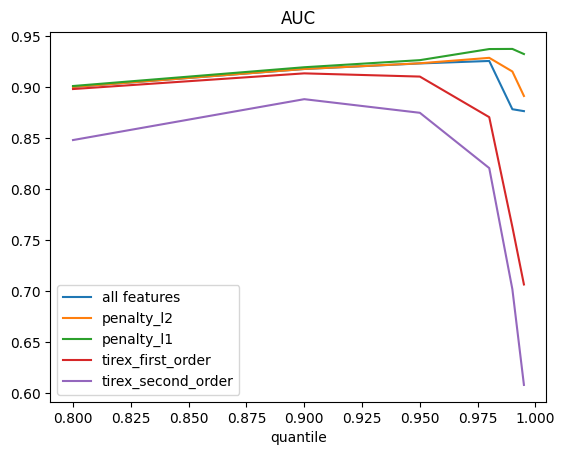

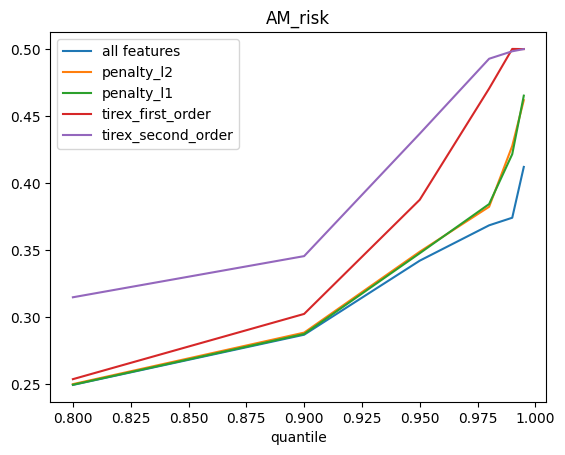

In [ ]:
# noise = 1

plot_results(predictions_storage_AUC_multiple, predictions_storage_AM_risk_multiple, x_axis = "quantile")

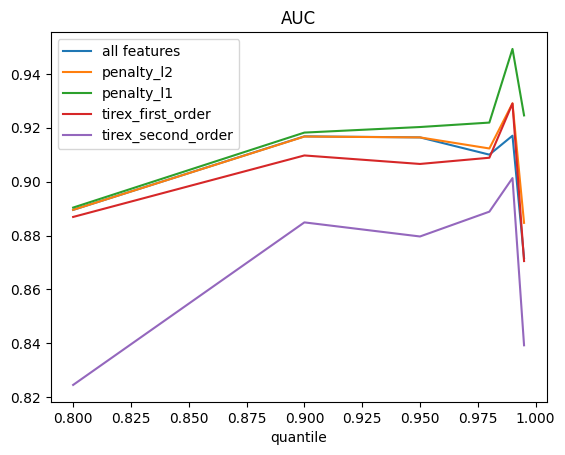

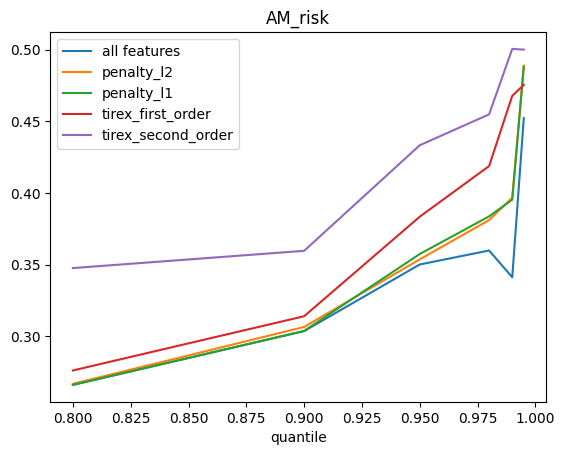

In [ ]:
# noise = 1

plot_results(predictions_storage_AUC_multiple, predictions_storage_AM_risk_multiple, x_axis = "quantile")

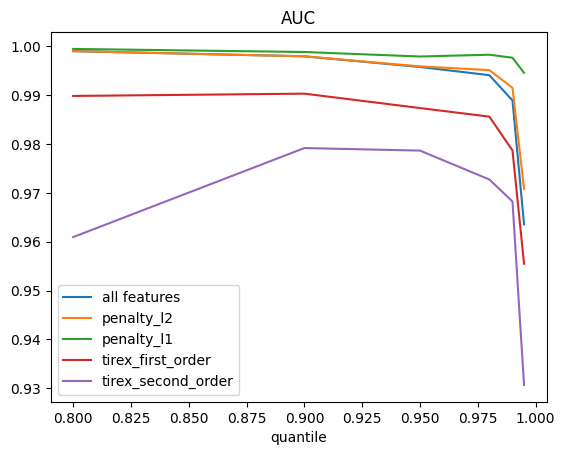

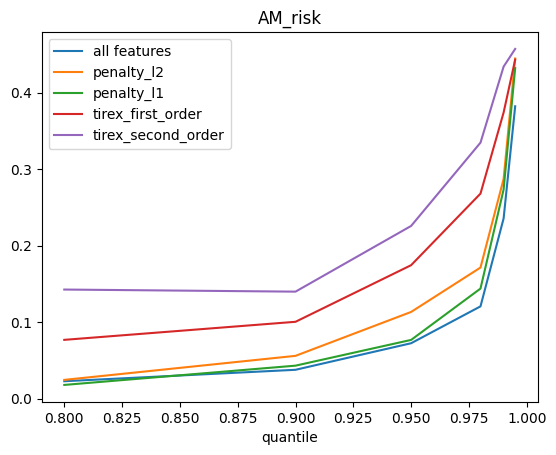

In [ ]:
plot_results(predictions_storage_AUC_multiple, predictions_storage_AM_risk_multiple, x_axis = "quantile")

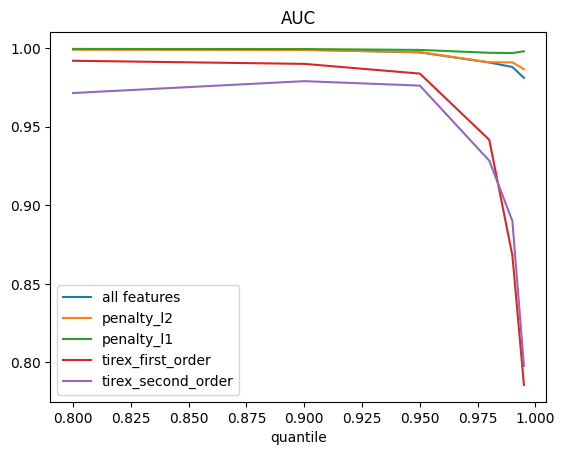

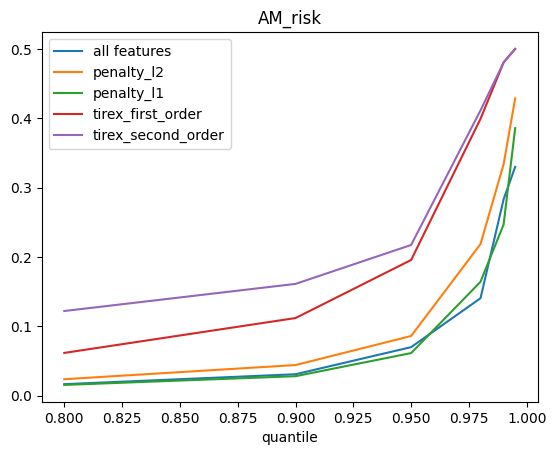

In [ ]:
plot_results(predictions_storage_AUC_multiple, predictions_storage_AM_risk_multiple, x_axis = "quantile")

# Sandbox

<Axes: xlabel='p_over_N'>

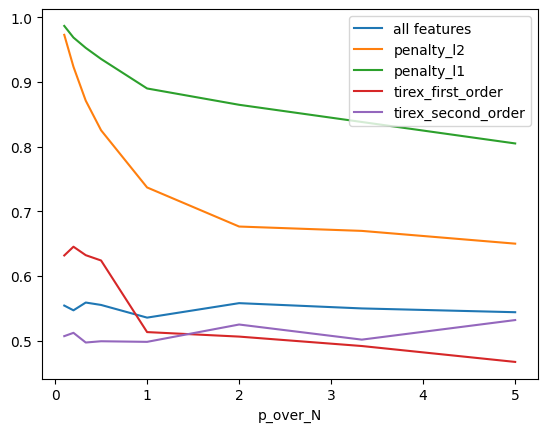

In [ ]:
predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.groupby('p_over_N', as_index=False).mean()
predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.groupby('p_over_N', as_index=False).mean()

predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.set_index("p_over_N")
predictions_storage_AUC_multiple = predictions_storage_AUC_multiple.drop("quantile", axis = 1)
predictions_storage_AUC_multiple.plot()
plt.title("AUC")
plt.show()

predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.set_index("p_over_N")
predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.drop("quantile", axis = 1)
predictions_storage_AM_risk_multiple.plot()
plt.title("AM_risk")
plt.show()

<Axes: xlabel='p_over_N'>

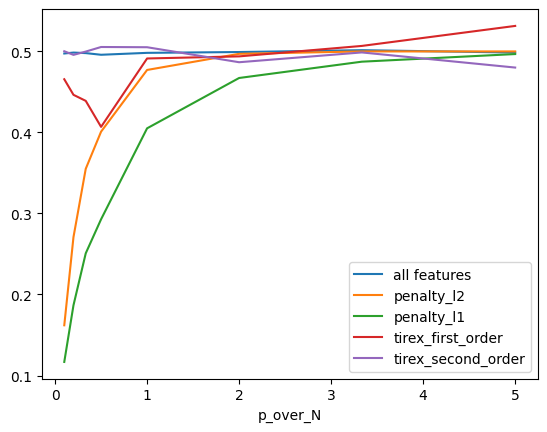

In [ ]:
predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.set_index("p_over_N")
predictions_storage_AM_risk_multiple = predictions_storage_AM_risk_multiple.drop("quantile", axis = 1)
predictions_storage_AM_risk_multiple.plot()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.manifold import Isomap,LocallyLinearEmbedding
from math import sqrt



algo={"all features":None,"tirex_first_order":TIREX(k=k_opt_FO,n_components=dim,method="FO"),"tirex_second_order":TIREX(k=k_opt_SO,n_components=dim,method="SO"),"CUME FO":TIREX(n_components=dim,method="FO",mode="CUME"),"CUME SO":TIREX(n_components=dim,method="SO",mode="CUME"),'PCA':PCA(n_components=dim),'SVD':TruncatedSVD(n_components=dim),"LLE":LocallyLinearEmbedding(n_components=dim,eigen_solver="dense"),"IMP":Isomap(n_components=dim,eigen_solver="dense")}




predictions_extreme_storage=test_model(algo,dim,model,X_train,Y_train,X_test,Y_test)


 AUC using all features on the  test set: 0.9118104118104118 

 AUC using tirex_first_order on the  test set: 0.9098679098679099 

 AUC using tirex_second_order on the  test set: 0.7346542346542346 

 AUC using CUME FO on the  test set: 0.8741258741258741 

 AUC using CUME SO on the  test set: 0.9557109557109557 

 AUC using PCA on the  test set: 0.8092463092463092 

 AUC using SVD on the  test set: 0.8108003108003108 

 AUC using LLE on the  test set: 0.7921522921522921 

 AUC using IMP on the  test set: 0.7766122766122767 



   p_over_N  all features_mean  penalty_l2_mean  penalty_l1_mean  \
0  5.000000           0.574691         0.653086         0.813580   
1  3.333333           0.527435         0.659534         0.779424   
2  2.000000           0.508444         0.658864         0.825086   
3  1.000000           0.540654         0.741654         0.898296   
4  0.500000           0.560256         0.826747         0.942222   
5  0.333333           0.524376         0.861407         0.948167   
6  0.200000           0.565607         0.919775         0.967806   
7  0.100000           0.556021         0.973724         0.987089   

   tirex_first_order_mean  tirex_second_order_mean  p_over_N_mean  \
0                0.495988                 0.541975       5.000000   
1                0.549931                 0.487106       3.333333   
2                0.501679                 0.551160       2.000000   
3                0.504679                 0.466123       1.000000   
4                0.535670                 

<Axes: xlabel='p_over_N_mean'>

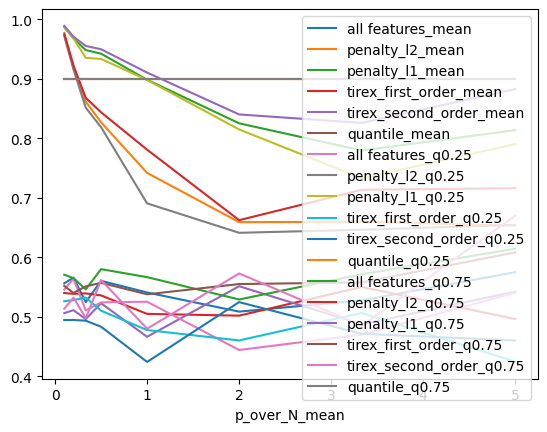

In [ ]:
df = predictions_storage_AUC_multiple
# Assuming 'p_over_N' is the column you're interested in
unique_values = df['p_over_N'].unique()

result_df = pd.DataFrame(columns=['p_over_N', 'mean', 'q0.25', 'q0.75'])

for value in unique_values:
    subset = df[df['p_over_N'] == value]

    # Calculate mean, quantiles, and store the results
    mean_value = subset.mean()
    q25 = subset.quantile(0.25)
    q75 = subset.quantile(0.75)

    result_df = result_df.append({
        'p_over_N': value,
        'mean': mean_value,
        'q0.25': q25,
        'q0.75': q75
    }, ignore_index=True)

# Display the result DataFrame
print(result_df)
